## BC203: Assignment 2 – Clustering

**Author:** Georgios Kousis Tsampazis

---

### Background

Clustering is the task of dividing the population or data points into several groups. Data points in the same
group are similar to those in the same group and dissimilar to those in the different groups. It is a collection
of objects based on their similarities and dissimilarities.

### Overview

Your assignment is to execute clustering methods on a synthetic data set derived from the well-known
machine learning module in Python called scikit-learn (https://scikit-learn.org/stable/). We will generate
synthetic data in the multidimensional space.

---

### Part 1: Custom Kmeans

1. **Data Generation**

   * Use the function `sklearn.datasets.make_blobs`.
2. **Costum Kmeans Function**
   * Init centers 
   * Repeat until convergence:
      a. Compute Di,kDi,k​ for each distance metric
      b. Assign each point to nearest center
      c. Recompute centers (handle empty clusters)
      d. Check shift < tol
   * Return final centers, labels, and inertia
3. **Mixture of Gaussians Function**
   a. Random initialization
   b. K-means initialization

---
### Part 2: Visualization

### Part 3: Noise Comparison

1. **Generate Noisy Data**
2. **Compare different algorithms**
### Part 4: Results 
<u>**If you don't care about code and just care about the results (*e.g. which method works better and why for various noise levels*), skip to this part**</u>.\
For the assignment perpuse this is more in line with the previous report structure! 

---

## Notebook Structure

1. **Setup & Dependencies**

2. **Data Preparation**

3. **Algorithms Implementation**

4. **Visualization & Interpretation**
5. **Discussion&Results**

---

> *>Our Analysis shows that there are three kinds of people in the world:* \
*>Those who use k-means clustering with k=3, and two other types whose qualitive interpretation is unclear* 

---


### Noteboook dependencies
*As always a conda enviroment is recommended for easier installation*

In [2]:
pip install scikit-learn numpy matplotlib seaborn pandas

Note: you may need to restart the kernel to use updated packages.


---
### Data Generation

We use scikit-learn’s `make_blobs` to generate a toy clustering dataset with 1,000 samples in 10-dimensional space. The points are drawn from four Gaussian clusters (std = 3.0), and for reproducibility we set `random_state` to the last two digits of my student ID.


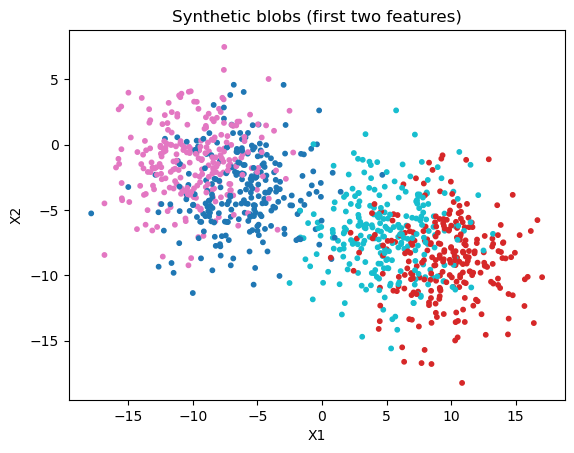

In [3]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000,n_features=10,centers=4,cluster_std=3.0,random_state=91)
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap='tab10')
plt.title("Synthetic blobs (first two features)")
plt.xlabel("X1"); plt.ylabel("X2")
plt.show()

***Figure 1:** Scatter plot of synthetic data (first two features) generated `using make_blobs`. True cluster labels are shown by color. Standard deviation is set to 3.0, resulting in 4 moderately separated clusters.*

Sure! Here's an updated version of the markdown with a section that clearly explains each supported distance metric:

---

### Custom K-Means Function

The `kmeans` function clusters an input dataset `data` into `n_clusters` using a manual K-Means algorithm. It supports three distance metrics: `euclidean`, `manhattan`, and `mahalanobis`. It initializes centroids with the **K-Means++** strategy (default) or **uniform random seeding**. The function iterates assignment and update steps until centroid movement falls below a tolerance (`tol`) or a maximum number of iterations (`max_iter`) is reached. It returns the final cluster centers, the label of each sample, and the clustering inertia.

#### Supported Distance Metrics

* **Euclidean**:
  The standard straight-line (L2) distance between two points.
  Formula:

  $$
  d(x, y) = \sqrt{\sum_i (x_i - y_i)^2}
  $$

* **Manhattan**:
  It sums the absolute differences along each dimension.
  Formula:

  $$
  d(x, y) = \sum_i |x_i - y_i|
  $$

* **Mahalanobis**:
  Accounts for correlations between features and scales the distances accordingly using the inverse covariance matrix.
  Formula:

  $$
  d(x, y) = \sqrt{(x - y)^T S^{-1} (x - y)}
  $$

  where $S$ is the covariance matrix of the data.



In [58]:
import numpy as np

def kmeans(data, n_clusters=4, distance='euclidean', init='kmeans++', max_iter=100, tol=1e-4, random_state=91):
    """
    A manual K-Means implementation supporting Euclidean, Manhattan, and Mahalanobis distances.

    Parameters:
    - data : ndarray (n_samples, n_features)
    - n_clusters : number of clusters
    - distance : 'euclidean', 'manhattan', 'mahalanobis'
    - init : 'kmeans++' or 'random', initialization method
    - max_iter : maximum number of iterations
    - tol : convergence tolerance on centroid movement
    - random_state : seed for reproducibility

    Returns:
    - centroids : ndarray (n_clusters, n_features)
    - labels : cluster assignment of samples
    - inertia : sum of squared Euclidean distances
    """
    np.random.seed(random_state)
    n_samples, n_features = data.shape
    # 1) Initialization
    if init == 'random':
        # sample k points uniformly
        idx = np.random.choice(n_samples, n_clusters, replace=False)
        centroids = data[idx].astype(float)
    elif init == 'kmeans++':
        # K-Means++ initialization
        centroids = np.zeros((n_clusters, n_features), dtype=float)
        centroids[0] = data[np.random.choice(n_samples)]
        for i in range(1, n_clusters):
            dist_sq = np.min(
                [np.sum((data - centroids[j])**2, axis=1) for j in range(i)],
                axis=0
            )
            probs = dist_sq / np.sum(dist_sq)
            centroids[i] = data[np.random.choice(n_samples, p=probs)]
    else:
        raise ValueError("init must be 'kmeans++' or 'random'")

    # 2) Precompute inverse covariance for Mahalanobis if needed
    if distance == 'mahalanobis':
        VI = np.linalg.inv(np.cov(data, rowvar=False))

    # 3) Main loop
    for iteration in range(1, max_iter + 1):
        # compute distance matrix for given choise 
        D = np.zeros((n_samples, n_clusters))
        for k in range(n_clusters):
            diff = data - centroids[k]
            if distance == 'euclidean':
                D[:, k] = np.linalg.norm(diff, axis=1)
            elif distance == 'manhattan':
                D[:, k] = np.sum(np.abs(diff), axis=1)
            elif distance == 'mahalanobis':
                # sqrt(diff.T @ VI @ diff) for each sample
                D[:, k] = np.sqrt(
                    np.einsum('ij,jk,ik->i', diff, VI, diff) # The more you know 
                )
            else:
                raise ValueError(
                    "Distance must be 'euclidean', 'manhattan', or 'mahalanobis'"
                )

        # assign labels
        labels = np.argmin(D, axis=1)

        # update centroids
        new_centroids = np.zeros_like(centroids) # Cool way 
        for k in range(n_clusters):
            members = data[labels == k]
            if members.size:
                new_centroids[k] = np.mean(members, axis=0)
            else:
                new_centroids[k] = centroids[k]

        # check convergence
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if shift < tol:
            break

    # compute inertia
    inertia = np.sum((data - centroids[labels])**2)
    return centroids, labels, inertia

 ### Mixture of Gaussians Function
 <u>Utilized sklearn</u>
>A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

This wrapper supports all avaible inits:
* `random_from_data`: Pick initial means by sampling actual data points at random.
* `kmeans`: Run K-means clustering first, then use its cluster centers as Gaussian means. 
* `kmeans++`:  K-means initialization that spreads out the initial centers to cover the data more evenly.
* `random`:  Choose means completely at random (inside data range).


In [5]:
def MoG(data, n_components=4, init='random_from_data', max_iter=100, random_state=None):
    from sklearn.mixture import GaussianMixture
    if init=='random_from_data': # Matches more the abover random implementation 
        gm = GaussianMixture(
            n_components=n_components, 
            covariance_type='full',
            init_params='random_from_data',
            max_iter=max_iter,
            random_state=random_state)
    elif init=='kmeans':
        gm = GaussianMixture(
            n_components=n_components,
            covariance_type='full',
            init_params='kmeans',
            max_iter=max_iter,
            random_state=random_state)
    elif init=='kmeans++':
        gm = GaussianMixture(
            n_components=n_components,
            covariance_type='full',
            init_params='kmeans',
            max_iter=max_iter,
            random_state=random_state)
    elif init=='random':
        gm = GaussianMixture(
            n_components=n_components,
            covariance_type='full',
            init_params='kmeans',
            max_iter=max_iter,
            random_state=random_state)
    else:
        raise ValueError("Init must be 'random' or 'random_from_data' or 'kmeans' or 'kmeans++'")
    
    gm.fit(data)
    labels = gm.predict(data)
    return gm.means_, labels, gm.lower_bound_

---
### Visualization

In [6]:
import matplotlib.pyplot as plt

def plotkmeans(
    data, 
    centers, 
    labels, 
    figsize=(8, 6), 
    cmap='tab10', 
    alpha=0.6, 
    center_color='black', 
    center_marker='x', 
    center_size=200,
    title='K-Means Clustering',
    xlabel='Feature 1',
    ylabel='Feature 2'
):
    plt.figure(figsize=figsize)
    # Plot each cluster
    plt.scatter(
        data[:, 0], 
        data[:, 1], 
        c=labels, 
        cmap=cmap, 
        alpha=alpha, 
        edgecolor='k',
        linewidth=0.5
    )
    # Mark centroids
    plt.scatter(
        centers[:, 0], 
        centers[:, 1], 
        c=center_color, 
        marker=center_marker, 
        s=center_size, 
        label='Centroids'
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

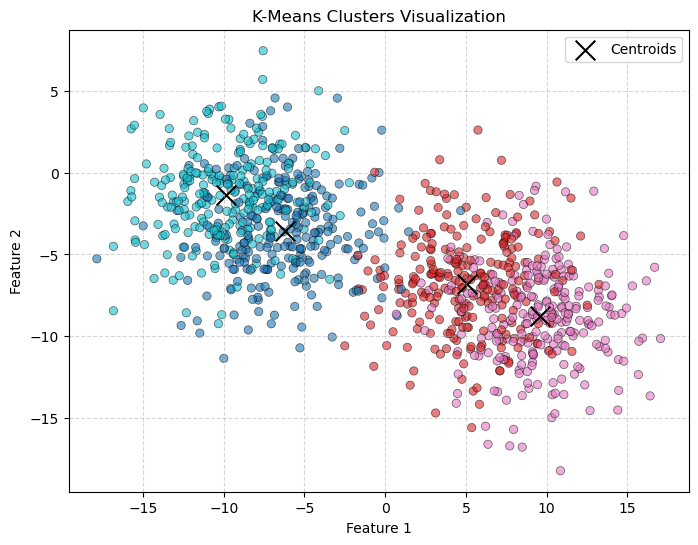

In [7]:
cen, lbls, _ = kmeans(X, n_clusters=4, random_state=91,distance='manhattan')
plotkmeans(X, cen, lbls, title='K-Means Clusters Visualization')

***Figure 2:** K-Means clustering result on the synthetic dataset (std = 3.0), using the Manhattan distance. Predicted clusters are shown with colored points and the centroids are marked with black "X".*

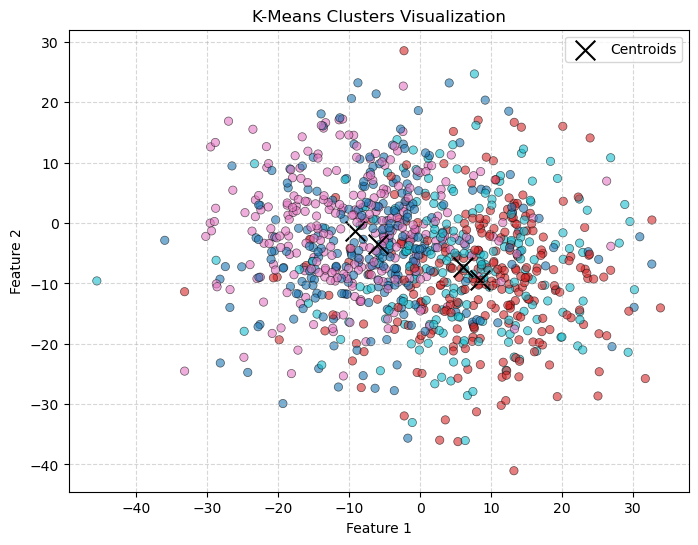

In [8]:
Xn, yn = make_blobs(n_samples=1000,n_features=10,centers=4,cluster_std=10.0,random_state=91)
cen, lbls, _ = kmeans(Xn, n_clusters=4, random_state=91,distance='manhattan')
plotkmeans(Xn, cen, lbls, title='K-Means Clusters Visualization')

***Figure 3**: K-Means clustering on a noisier version of the dataset (std = 10.0). Clusters show heavy overlap, which increases misclassification risk and causes centroid drift.*

As we can see from *Figures 2 and 3*, as the standard deviation increases, the clusters begin to overlap more significantly. This visual observation suggests that higher noise levels may lead to misclustered points, as the boundaries between clusters become less distinct and the centroids are drawn closer to each other.

---
### Noise Comparison
To evaluate the effectiveness of different clustering algorithms under varying levels of noise, I conduct a benchmark using datasets generated with different standard deviations (std). These deviations simulate increasing cluster overlap, making the clustering task more challenging as noise increases.

I assess performance using two key evaluation metrics:
 * **Silhouette Coefficient *(Internal Index)*:** Measures the quality of clustering without reference to true labels. It evaluates how similar a point is to its own cluster compared to others. Higher scores indicate well-defined, separated clusters. It ranges from -1 to 1
 * **Adjusted Rand Index (ARI) *(External Index)*:** Measures similarity between predicted cluster labels and the ground truth. Although ARI is sometimes labeled as a relative index, it is more accurately considered an external index in our case because it compares true class labels. ARI adjusts for random label agreement, with scores ranging from -1 (worse than random) to 1 (perfect match). 

Each algorithm (including variations in initialization and distance metrics) is tested across a range of standard deviations. I categorize the noise levels as:

`Low Noise: std ≤ 3.0`

`High Noise: std > 3.0`

After running all experiments, I compute both the mean and median scores across noise levels for each algorithm configuration. These aggregated results help determine which clustering method is most robust and consistent under increasing noise.

In [45]:
import pandas as pd
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, silhouette_score

# 1) Benchmark settings
cluster_stds     = [1.0, 2.0, 3.0, 5.0, 8.0, 10.0]
kmeans_distances = ['euclidean', 'manhattan', 'mahalanobis']
kmeans_inits     = ['kmeans++', 'random']
mog_inits        = ['random_from_data','random', 'kmeans','kmeans++']

results = []

# 2) Run Benchmark
for std in cluster_stds:
    X, y_true = make_blobs(
        n_samples=1000, n_features=10, centers=4,
        cluster_std=std, random_state=91
    )
    # K-Means variants
    for dist in kmeans_distances:
        for init in kmeans_inits:
            _, labels_k, _ = kmeans(X, n_clusters=4, distance=dist, init=init, random_state=91)
            results.append({
                'method': 'KMeans',
                'parameter': f"{dist}-{init}",
                'cluster_std': std,
                'ARI': adjusted_rand_score(y_true, labels_k),
                'Silhouette': silhouette_score(X, labels_k, metric=dist)
            })
    # MoG variants
    for init in mog_inits:
        _, labels_m, _ = MoG(X, n_components=4, init=init, random_state=91)
        results.append({
            'method': 'MoG',
            'parameter': init,
            'cluster_std': std,
            'ARI': adjusted_rand_score(y_true, labels_m),
            'Silhouette': silhouette_score(X, labels_m, metric='euclidean')
        })

# 3) Create DataFrame
df = pd.DataFrame(results)
# print(df)

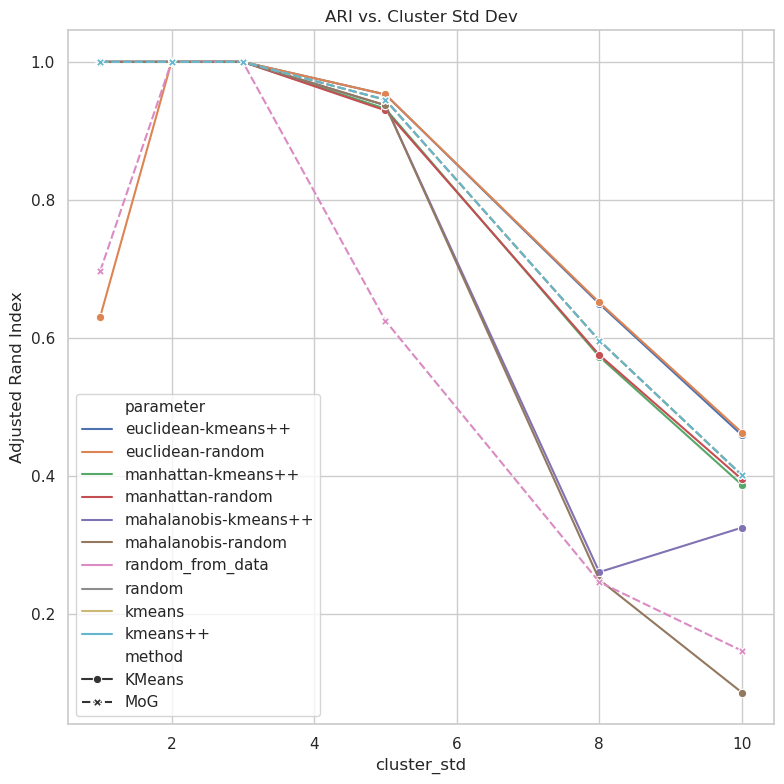

In [46]:
# 1)Plot ARI vs. noise
sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
sns.lineplot(
    data=df, x='cluster_std', y='ARI',
    hue='parameter', style='method', markers=True
)
plt.title("ARI vs. Cluster Std Dev")
plt.xlabel("cluster_std")
plt.ylabel("Adjusted Rand Index")
plt.tight_layout()
plt.show()

***Figure 4**: Line plot of Adjusted Rand Index (ARI) versus cluster standard deviation for all algorithm variants. The ARI decreases with noise, indicating reduced clustering accuracy.*

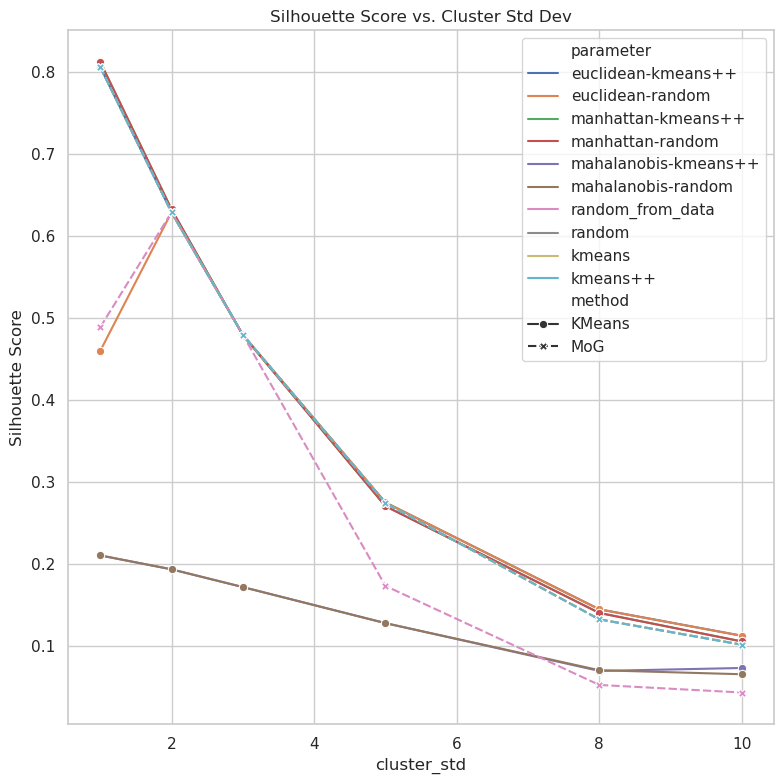

In [47]:
# 2) Plot Silhouette vs. noise
plt.figure(figsize=(8, 8))
sns.lineplot(
    data=df, x='cluster_std', y='Silhouette',
    hue='parameter', style='method', markers=True
)
plt.title("Silhouette Score vs. Cluster Std Dev")
plt.xlabel("cluster_std")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

***Figure 5**: Silhouette Score plotted against cluster standard deviation. This internal index reflects how well-separated the clusters are. Higher noise results in lower silhouette scores.*

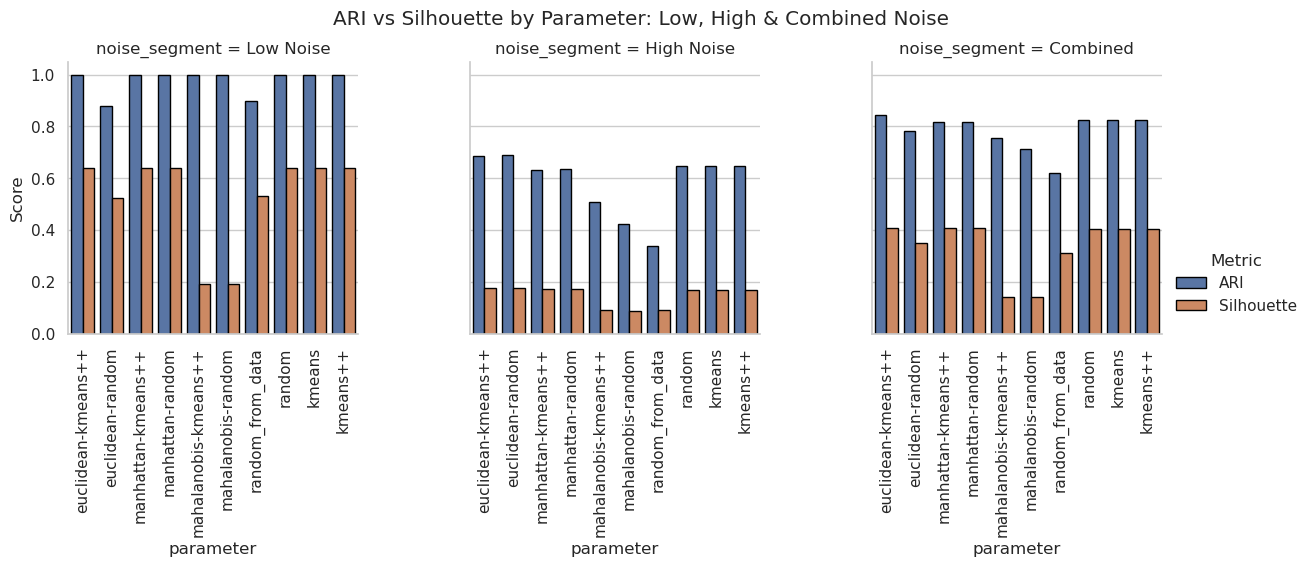

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Tag noise segments
df['noise_segment'] = np.where(df['cluster_std'] <= 3.0, 'Low Noise', 'High Noise')

# 2) Melt to long form (only the columns we need)
df_long = df.melt(
    id_vars=['parameter', 'noise_segment'],
    value_vars=['ARI', 'Silhouette'],
    var_name='Metric',
    value_name='Score'
)

# 3) Create a “Combined” copy
df_combined = df_long.copy()
df_combined['noise_segment'] = 'Combined'

# 4) Stack them together
df_aug = pd.concat([df_long, df_combined], ignore_index=True)

# 5) Plot faceted by noise_segment (Low, High, Combined)
g = sns.catplot(
    data=df_aug,
    x='parameter',
    y='Score',
    hue='Metric', 
    col='noise_segment',
    col_order=['Low Noise','High Noise','Combined'],
    kind='bar',
    errorbar=None,   # turn off those black ticks
    edgecolor='black',
    height=4,
    aspect=1
)

g.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.85)
plt.suptitle("ARI vs Silhouette by Parameter: Low, High & Combined Noise")
plt.show()


***Figure 6:** Bar chart of mean ARI & Silhouette scores for different algorithm configurations, separated by low (≤3) and high (>3) noise segments. Useful for identifying robust clustering setups.* Last subplot contains the combined mean scores from all runs

In [53]:
# Determine best method by median ARI (cool groupby)
median_ari = df.groupby(['method','parameter'])['ARI']\
               .median()\
               .reset_index(name='Median_ARI')\
               .sort_values('Median_ARI', ascending=False)

print("Median ARI ranking:")
print(median_ari)

best = median_ari.iloc[0]
print(f"\nBest overall: {best['method']} with parameter '{best['parameter']}' (median ARI={best['Median_ARI']:.3f})")

Median ARI ranking:
   method             parameter  Median_ARI
0  KMeans    euclidean-kmeans++    0.976376
6     MoG                kmeans    0.972548
7     MoG              kmeans++    0.972548
8     MoG                random    0.972548
3  KMeans    mahalanobis-random    0.968563
2  KMeans  mahalanobis-kmeans++    0.968560
4  KMeans    manhattan-kmeans++    0.966100
5  KMeans      manhattan-random    0.964852
1  KMeans      euclidean-random    0.802199
9     MoG      random_from_data    0.661081

Best overall: KMeans with parameter 'euclidean-kmeans++' (median ARI=0.976)


In [66]:
# Determine best method by median ARI (cool groupby)
mean_ari = df.groupby(['method','parameter'])['ARI']\
               .mean()\
               .reset_index(name='Mean_ARI')\
               .sort_values('Mean_ARI', ascending=False)

print("Mean ARI ranking:")
print(mean_ari)

best = mean_ari.iloc[0]
print(f"\nBest overall: {best['method']} with parameter '{best['parameter']}' (mean ARI={best['Mean_ARI']:.3f})")

Mean ARI ranking:
   method             parameter  Mean_ARI
0  KMeans    euclidean-kmeans++  0.843651
6     MoG                kmeans  0.823852
7     MoG              kmeans++  0.823852
8     MoG                random  0.823852
5  KMeans      manhattan-random  0.816817
4  KMeans    manhattan-kmeans++  0.815482
1  KMeans      euclidean-random  0.783116
2  KMeans  mahalanobis-kmeans++  0.753989
3  KMeans    mahalanobis-random  0.712365
9     MoG      random_from_data  0.619366

Best overall: KMeans with parameter 'euclidean-kmeans++' (mean ARI=0.844)


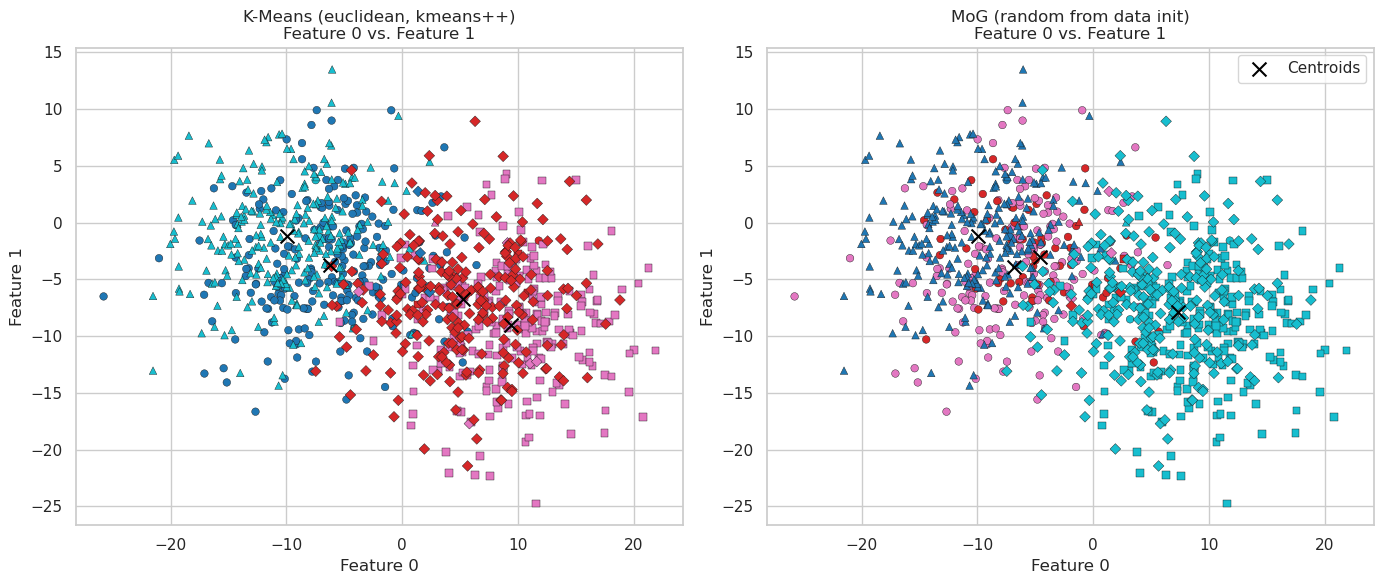

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Generate data
X, y_true = make_blobs(
    n_samples=1000,
    n_features=10,
    centers=4,
    cluster_std=5.0,
    random_state=91
)

# 2) Fit clustering models
cent_k, labels_k, _ = kmeans(
    X,
    n_clusters=4,
    distance='euclidean',
    init='kmeans++',
    random_state=91
)

cent_m, labels_m, _ = MoG(
    X,
    n_components=4,
    init='random_from_data',
    random_state=91
)

# 3) Use raw features 0 and 1 for plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

titles = [
    "K-Means (euclidean, kmeans++)",
    "MoG (random from data init)"
]
results = [
    (labels_k, cent_k),
    (labels_m, cent_m)
]

shapes = ['o', 's', '^', 'D']  # One shape per true label
cmap = plt.get_cmap('tab10', 4)  # 4 distinct cluster colors
norm = plt.Normalize(vmin=0, vmax=3)  # normalize labels to colormap range

for ax, (labels_pred, centroids), title in zip(axes, results, titles):
    for true_label in np.unique(y_true):
        mask = (y_true == true_label)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=labels_pred[mask],
            cmap=cmap,
            norm=norm,
            marker=shapes[true_label],
            edgecolor='k',
            linewidth=0.3,
            s=30
        )

    # Plot centroids
    ax.scatter(
        centroids[:, 0], centroids[:, 1],
        c='black', marker='x',
        s=100,
        label='Centroids'
    )

    ax.set_title(f"{title}\nFeature 0 vs. Feature 1")
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


**Figure 7:** *Side-by-side comparison of cluster assignments from K-Means (left) and Gaussian Mixture Models (right). Points are shaped by ground-truth class and colored by predicted cluster. K-Means with euclidean distance and non-random init shows smoother boundaries and more seperated centers in noisy conditions. It performs better since it has less shapes (shape=True Labebl) of differnt colors (Assigned Label).*

---

### **Results**
#### **General Results**
* Across all scenarios, K-Means with Euclidean distance and KMeans++ initialization outperformed or matched all other clustering methods, even in the presence of substantial noise. As seen in Figure 6, it is consistently the best candidate or among the top candidates in the Low Noise, High Noise, and Combined metrics.
* Throughout benchmarking, random initialization tends to match or perform worse than non-random initialization when comparing similar configurations (same algorithm with different initializations), never better. Random centroid selection can place starting points too close together, trapping the algorithm in suboptimal solutions. In contrast, KMeans++ for example, strategically spaces initial centroids according to the data distribution. This careful seeding reduces the chance of converging to poor local optima and helps accurately recover the true cluster structure. One notable exception is the MoG (Mixture of Gaussians) algorithm, where random initialization performed comparably to KMeans and KMeans++ initializations. The random-from-data initialization for MoG performed worse, showing that inappropriate initialization can harm even probabilistic clustering methods. The worse performance of the random-from-data initialization compared to pure random in the MoG implementation can be attributed to bad initializations that are more likely when choosing actual data points, especially for High-Noise Conditions since picks may fall into regions where true cluster identity is ambiguous. 

* **Distance metrics comparison (Specifically for kmeans)**: Euclidean distance calculating the straight‐line distance via the square root of summed squared differences, best matches the spherical nature of our clusters, yielding the most accurate assignments. Manhattan distance, which sums the absolute differences across dimensions, underperforms because it ignores correlations between features and doesn't align with the shape of the clusters. Mahalanobis distance, while accounting for feature covariance, gives the worst results in this setup. Since the clusters are spherical with equal variance, Mahalanobis' complexity offers no benefit and may even introduce numerical noise.
#### **Performance in Low-Noise Conditions (std ≤ 3.0):**
All clustering algorithms performed well, with high ARI scores (> 0.85) and Silhouette scores between 0.5–0.7, except for those using Mahalanobis distance. Although these sometimes achieved high ARI, their Silhouette scores suffered, indicating poor intra-cluster cohesion despite correct label assignments.

* Notably, performance variance was most visible at std = 1.0, where four algorithms had significantly worse results compared to others:
    * In terms of Silhouette score:
        * KMeans + Mahalanobis + Random
        * KMeans + Mahalanobis + KMeans++
        * MoG + Random-from-Data
        * KMeans + Euclidean + Random
    * In terms of ARI score:
        * MoG + Random-from-Data
        * KMeans + Euclidean + Random
        
This confirms earlier observations: Mahalanobis performs worse, and random init or random-from-data can degrade performance significantly in some cases. Notably, the Euclidean + Random variant of KMeans underperformed,in low-noise conditions, compared to its KMeans++ variant.Though other algorithms (e.g. Kmeans+ Manhattan) appeared more resilient to random initialization.

Again the poor performance of Mahalanobis distance likely stems from the data's nature: the synthetic blobs are nearly spherical and isotropic, so Mahalanobis "whitening" doesn't correct anything meaningful and instead injects noise.

<u>**KMeans with Euclidean distance and KMeans++ initialization consistently achieved the best performance across all low-noise scenarios.**</u>
#### **Performance in High-Noise Conditions (std > 3.0):**
As noise increased:
* **Silhouette scores declined** significantly, showing reduced internal cohesion and more cluster overlap.
* **ARI scores dropped** for both KMeans and MoG variants, with a slightly larger drop in randomly initialized configurations—especially those using Mahalanobis.

While Gaussian Mixture Models with KMeans initialization offer more flexibility (via soft assignments), results showed that KMeans with Euclidean distance and KMeans++ or even Random initialization matched or outperformed MoG—even under high-noise conditions. This suggests that KMeans remains competitive across a range of noise levels, particularly when the data aligns well with Euclidean assumptions (i.e., spherical clusters).
#### **Best Overall Performers:**
In both low noise and high noise scenarios, <u>**KMeans with Euclidean distance and KMeans++ initialization**</u> (as shown in **Figure 7**) emerged as the most reliable:
* It accurately assigned samples to correct clusters (high ARI).
* It maintained high Silhouette scores, meaning that even when errors occurred, the resulting clusters remained compact and well-separated.
#### Metric Trends:

* **Silhouette Score** decreased steadily as `cluster_std` increased, reflecting  increasingly overlapping clusters and less clear boundaries.
* **ARI** showed a similar trend but varied more depending on algorithm configuration.

---
### **Key Takeaway**
There is no one size fits all clustering algorithm, more complexity does not guarantee better performance. Results show that algorithm effectiveness depends heavily on the structure and characteristics of the data. Methods like Mahalanobis distance or Gaussian mixtures, while theoretically more flexible, may underperform when their assumptions don't align with the data (e.g., spherical, equally sized clusters). Therefore, each clustering task should begin with an assessment of the data's geometry and variability or I guess you can always benchmark your way out (like I did) / test multiple methods. Only then you can identify the algorithm that best fits the specific data structure at hand.